# https://www.kaggle.com/c/ml-marathon-final/overview

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


In [2]:
datasets_train_path = '../input/kaggle_dogcat/train/'
datasets_test_path = '../input/kaggle_dogcat/test/'
print(os.listdir(datasets_train_path))

['cat.10001.jpg', 'cat.10002.jpg', 'cat.10005.jpg', 'cat.10008.jpg', 'cat.10024.jpg', 'cat.10025.jpg', 'cat.10029.jpg', 'cat.1004.jpg', 'cat.10050.jpg', 'cat.10053.jpg', 'cat.10059.jpg', 'cat.1006.jpg', 'cat.10065.jpg', 'cat.10066.jpg', 'cat.10069.jpg', 'cat.1007.jpg', 'cat.10077.jpg', 'cat.10078.jpg', 'cat.1008.jpg', 'cat.10098.jpg', 'cat.10102.jpg', 'cat.10105.jpg', 'cat.10107.jpg', 'cat.10108.jpg', 'cat.10109.jpg', 'cat.10111.jpg', 'cat.10121.jpg', 'cat.10125.jpg', 'cat.1014.jpg', 'cat.10154.jpg', 'cat.10156.jpg', 'cat.1016.jpg', 'cat.10161.jpg', 'cat.10164.jpg', 'cat.10168.jpg', 'cat.10176.jpg', 'cat.1018.jpg', 'cat.10181.jpg', 'cat.10182.jpg', 'cat.10184.jpg', 'cat.10194.jpg', 'cat.10197.jpg', 'cat.10198.jpg', 'cat.10201.jpg', 'cat.10202.jpg', 'cat.10203.jpg', 'cat.10205.jpg', 'cat.10210.jpg', 'cat.10220.jpg', 'cat.10226.jpg', 'cat.10229.jpg', 'cat.10237.jpg', 'cat.10244.jpg', 'cat.10248.jpg', 'cat.1025.jpg', 'cat.10254.jpg', 'cat.10255.jpg', 'cat.10257.jpg', 'cat.10259.jpg', 'cat

In [3]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [4]:
filenames = os.listdir(datasets_train_path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [5]:
df.head()

,filename,category
0,cat.10001.jpg,0
1,cat.10002.jpg,0
2,cat.10005.jpg,0
3,cat.10008.jpg,0
4,cat.10024.jpg,0


In [6]:
df.tail()

,filename,category
3995,dog.9972.jpg,1
3996,dog.9974.jpg,1
3997,dog.9979.jpg,1
3998,dog.9982.jpg,1
3999,dog.9985.jpg,1


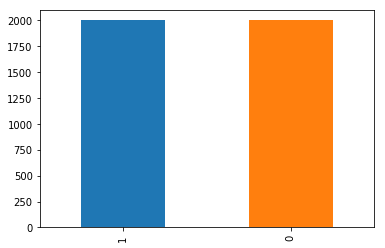

In [7]:
df['category'].value_counts().plot.bar()

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))) # input_shape => 128*128的彩色RGB图像
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu')) # Dense全連接層用在最後的維度
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [10]:
df['category'] = df['category'].replace({0:'cat', 1:'dog'})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42) # random_state 設為 42 用來確保每次切分資料的結果都相同
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

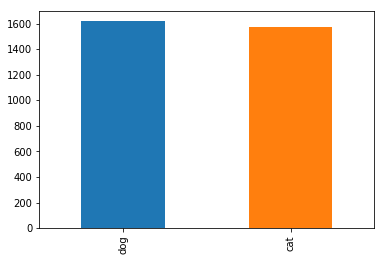

In [11]:
train_df['category'].value_counts().plot.bar()

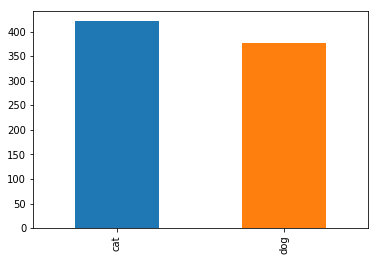

In [12]:
validate_df['category'].value_counts().plot.bar()

In [13]:
total_train = train_df.shape[0]
total_vaildate = validate_df.shape[0]
batch_size = 10

In [14]:
# https://keras.io/zh/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15, # 整数。随机旋转的度数范围
    rescale=1./255, # rescale: 重缩放因子。默认为 None。如果是 None 或 0，不进行缩放，否则将数据乘以所提供的值
    shear_range=0.1, # 浮点数。剪切强度（以弧度逆时针方向剪切角度）
    zoom_range=0.2, # 浮点数 或 [lower, upper]。随机缩放范围。如果是浮点数，[lower, upper] = [1-zoom_range, 1+zoom_range]
    horizontal_flip=True, # 布尔值。随机水平翻转
    width_shift_range=0.1, # 浮点数、一维数组或整数
    height_shift_range=0.1 # 浮点数、一维数组或整数
)

# flow_from_datafram => 獲取數據幀和目錄路徑，並生成批量的擴充/規範化數據
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    datasets_train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3200 images belonging to 2 classes.


In [15]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    datasets_train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 800 images belonging to 2 classes.


In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    datasets_train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 images belonging to 1 classes.


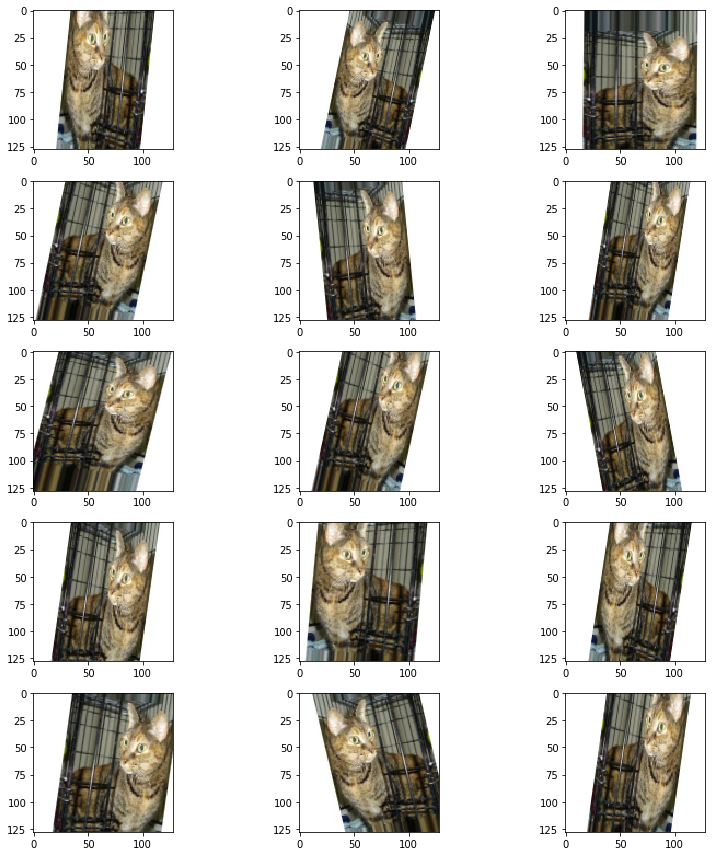

In [17]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1) # subplot多合一
    for X_batch, Y_baych in example_generator:
        image = X_batch[0]
        plt.imshow(image) # 返回一个matplotlib类型的数据
        break
plt.tight_layout() # tight_layout会自动调整子图参数
plt.show()

In [18]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, # generator：生成器函数，生成器
    epochs = epochs, # epochs：整数，数据迭代的轮数
    validation_data = validation_generator, # validation_data:生成验证集的生成器
    validation_steps = total_vaildate // batch_size, # validation_steps: 当validation_data为生成器时，本参数指定验证集的生成器返回次数
    steps_per_epoch = total_train // batch_size, # steps_per_epoch：整数，当生成器返回steps_per_epoch次数据时计一个epoch结束，执行下一个epoch
    callbacks = callbacks # callbacks：list，其中的元素是keras.callbacks.Callback的对象。这个list中的回调函数将会在训练过程中的适当时机被调用，参考回调函数
)

Epoch 1/50
320/320 [==============================] - 308s 962ms/step - loss: 1.1330 - acc: 0.5519 - val_loss: 1.2202 - val_acc: 0.4238
Epoch 2/50
320/320 [==============================] - 290s 907ms/step - loss: 0.7739 - acc: 0.5850 - val_loss: 1.0430 - val_acc: 0.4400
Epoch 3/50
320/320 [==============================] - 308s 962ms/step - loss: 0.7046 - acc: 0.5984 - val_loss: 0.9551 - val_acc: 0.3725
Epoch 4/50
320/320 [==============================] - 314s 982ms/step - loss: 0.6649 - acc: 0.6416 - val_loss: 1.1125 - val_acc: 0.3525

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
320/320 [==============================] - 314s 981ms/step - loss: 0.6233 - acc: 0.6503 - val_loss: 1.3528 - val_acc: 0.3650
Epoch 6/50
320/320 [==============================] - 313s 977ms/step - loss: 0.6089 - acc: 0.6706 - val_loss: 1.2573 - val_acc: 0.2525

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/50
320/320 [==

In [19]:
model.save_weights('model.h5')

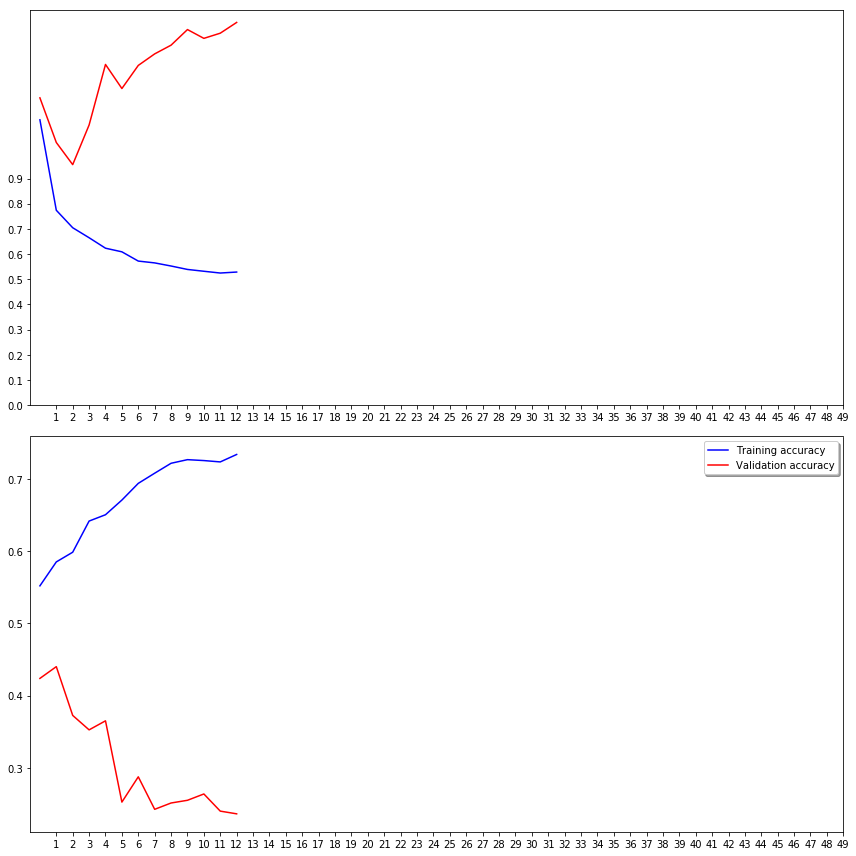

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [21]:
test_filenames = os.listdir(datasets_test_path)
test_df = pd.DataFrame({
    'filename':test_filenames
})
nb_samples = test_df.shape[0]

In [22]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    datasets_test_path, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 400 images.


In [23]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({'dog': 1, 'cat': 0 })

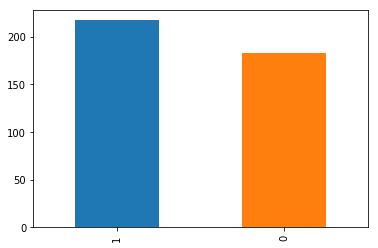

In [24]:
test_df['category'].value_counts().plot.bar()

000.jpg
001.jpg
002.jpg
003.jpg
004.jpg
005.jpg
006.jpg
007.jpg
008.jpg
009.jpg
010.jpg
011.jpg
012.jpg
013.jpg
014.jpg
015.jpg
016.jpg
017.jpg


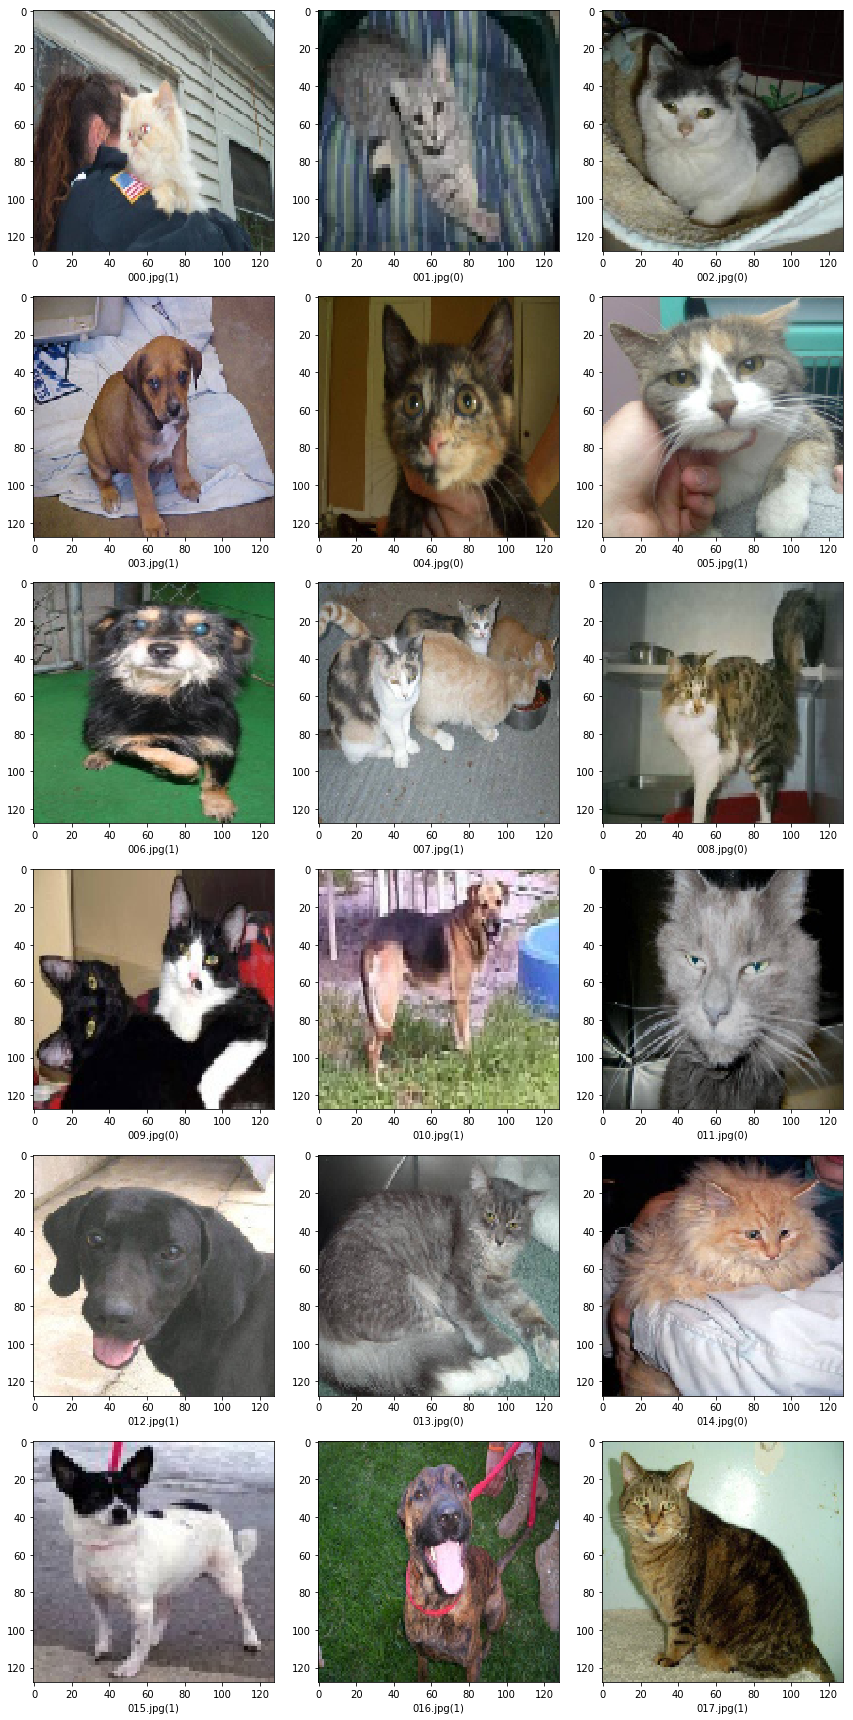

In [25]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    print(filename)
    img = load_img(datasets_test_path+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + '{}'.format(category) + ')' )
plt.tight_layout()
plt.show()

In [26]:
import time
date = time.strftime("%Y%m%d", time.localtime())

submission_df = test_df.copy()
submission_df['ID'] = submission_df['filename'].str.split('.').str[0]
submission_df['Predicted'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)

save_csv = str(date)+'submission.csv'
submission_df.to_csv(save_csv, index=False)
save_csv

'20190816submission.csv'